# GridWorld Example

Let's see how to make this API work with GridWorld! This reinforcement learning API requires 3 things to be defined before we start running algorithms:

+ BlackBoxModel: defines the problem--see below for an example!
+ Policy: this is where your domain knowledge comes in--define action space and feature functions
+ Solver: This is where the API takes over and you just specify what you want to use

In [1]:
include(joinpath("..","src","ReinforcementLearning.jl"))
using ReinforcementLearning

    action(ReinforcementLearning.Policy, ReinforcementLearning.ActorCritic, #T<:Any) at /home/chris/Documents/Research/ReinforcementLearning/src/policy.jl:208
is ambiguous with: 
    action(ReinforcementLearning.EpsilonGreedyPolicy, ReinforcementLearning.UpdaterParam, #T<:Any) at /home/chris/Documents/Research/ReinforcementLearning/src/policy.jl:127.
To fix, define 
    action(ReinforcementLearning.EpsilonGreedyPolicy, ReinforcementLearning.ActorCritic, #T<:Any)
before the new definition.
    action(ReinforcementLearning.Policy, ReinforcementLearning.ActorCritic, #T<:Any) at /home/chris/Documents/Research/ReinforcementLearning/src/policy.jl:208
is ambiguous with: 
    action(ReinforcementLearning.SoftmaxPolicy, ReinforcementLearning.UpdaterParam, #T<:Any) at /home/chris/Documents/Research/ReinforcementLearning/src/policy.jl:168.
To fix, define 
    action(ReinforcementLearning.SoftmaxPolicy, ReinforcementLearning.ActorCritic, #T<:Any)
before the new definition.


## Define Black Box Model Functions

The BlackBoxModel type requires the following things to be defined:
+ `model`: a generic type that holds all your model parameters for a specific instance of your problem
+ `init(model,rng)`: generate an initial state
+ `observe(model,rng,state,action=None)`: return an observation based on your state (and action--this isn't quite ironed out yet)
+ `next_state(model,rng,state,action)`: generate a next state given your state, action and problem parameterization
+ `reward(model,rng,state,action)`: generate a reward based on your state and action and problem parameterization
+ `isterminal(model,state,action)`: return a boolean of whether a state (and action) is terminal or not

In [2]:
using PyPlot
using Interact

typealias State Tuple{Int,Int}
typealias Action Tuple{Int,Int}

type GridWorldModel <: Model
  W::Int
  H::Int
  p_other::Float64
  reward_locs::Dict{State,Float64}
  collide_cost::Float64
    cost_of_living::Float64
    A::Array{Action,1}
end

In [3]:
init2(m::GridWorldModel,rng::AbstractRNG) = (rand(rng,1:m.W),rand(rng,1:m.H))
init1(m::GridWorldModel,rng::AbstractRNG) = (1,1)

isend1(rng::AbstractRNG,m::GridWorldModel,s::State,a::Action) = s in keys(m.reward_locs)
isend2(rng::AbstractRNG,m::GridWorldModel,s::State,a::Action) = false

function reward(rng::AbstractRNG,m::GridWorldModel,s::State,a::Action)
    r = get(m.reward_locs,s,0.)
  x_ = s[1] + a[1]
  y_ = s[2] + a[2]

  if (x_ < 1) || (x_ > m.W)
    r += m.collide_cost
  elseif (y_ < 1) || (x_ > m.H)
    r += m.collide_cost
  end
    
    r += m.cost_of_living #cost of living
    
  return r

end

function next(rng::AbstractRNG,m::GridWorldModel,s::State,a::Action)
    A_other = setdiff(m.A,[a,(-1*a[1],-1*a[2])])

  if rand(rng) < m.p_other
    _a = A_other[rand(rng,1:length(A_other))]
  else
    _a = a
  end
  x_ = s[1] + _a[1]
  y_ = s[2] + _a[2]

  x_ = max(min(x_,m.W),1)
  y_ = max(min(y_,m.H),1)

  return (x_,y_)
end

next (generic function with 1 method)

Here we also implement some quality of life functions, such as an explicity one-hot feature function for each state-action pair, and a visualization function

In [4]:

function generate_joint_featurefunction(m::GridWorldModel)

  nb_feat = m.W*m.H
  function feature_function(s::State)
    active_indices = [s[1]+m.W*(s[2]-1)]
    phi = sparsevec(active_indices,ones(length(active_indices)),nb_feat)
    return phi
  end
  return feature_function
end


function generate_disjoint_featurefunction(m::GridWorldModel)
    nb_feat = m.W + m.H
    function feature_function(s::State)
        active_indices = [s[1];m.W+s[2]]
        return sparsevec(active_indices,ones(2),nb_feat)
    end
end

function visualize(m::GridWorldModel,s::State,a::Action)
  #base grid
  for i = 1:m.W
    for j = 1:m.H
      val = get(m.reward_locs,(i,j),0.)
      if val > 0
        color = "#31B404"
      elseif val < 0
        color = "#FF0000"
      else
        color = "#A4A4A4"
      end
            fill([i;i+1;i+1;i],[j;j;j+1;j+1],color=color,edgecolor="#FFFFFF")
    end #j
  end #i

  #draw agent
  agent_color = "#0101DF"
  x = s[1] + 0.5
  y = s[2] + 0.5
  fill([x-0.5;x;x+0.5;x],[y;y-0.5;y;y+0.5],color=agent_color)
  #draw direction
  arrow(x,y,0.5*a[1],0.5*a[2],width=0.1,head_width=0.15,head_length=0.5)

end

function visualize(m::GridWorldModel,S::Array{State,1},A::Array{Action,1})
  assert(length(S) == length(A))
  f = figure()
  @manipulate for i = 1:length(S); withfig(f) do
    visualize(m,S[i],A[i]) end
  end
end

visualize (generic function with 2 methods)

In [5]:
_A = Action[(1,0),(-1,0),(0,1),(0,-1)]

4-element Array{Tuple{Int64,Int64},1}:
 (1,0) 
 (-1,0)
 (0,1) 
 (0,-1)

In [41]:
W = 10
H = 10
p_other = 0.001
"""
reward_locs = Dict{State,Float64}((W,H)=>10.,
                                    (floor(Int,W*3/4),floor(Int,H/2))=>-5.,
                                    (floor(Int,W/2),floor(Int,H*3/4))=>-5.,
                                    (floor(Int,W/4+1),floor(Int,H/4+1))=>-5.,
                                    (1,floor(Int,H/2))=>-5.,
                                    (W,floor(Int,H*3/4))=>-5.,
                                    (floor(Int,W/2),1)=>-5.,
                                    (floor(Int,W*3/4),H)=>-5.,)
"""
reward_locs = Dict{State,Float64}([(i,i)=>-5. for i=2:(min(W,H)-1)])
reward_locs[(W,H)] = 10.
for i = 1:4
    #reward_locs[(i,H-3+i)] = -5.
    #reward_locs[(W-3+i,i)] = -5.
    reward_locs[(W+1-i,i)] = -5.
    reward_locs[(i,H+1-i)] = -5.
end

reward_locs = Dict{State,Float64}((W,H)=>10.)

collide_cost = -1.
cost_of_living = -0.01
m = GridWorldModel(W,H,p_other,reward_locs,collide_cost,cost_of_living,_A)

GridWorldModel(10,10,0.001,Dict((10,10)=>10.0),-1.0,-0.01,[(1,0),(-1,0),(0,1),(0,-1)])

We now define the BlackBoxModel type. Note that we do not include an observation function in the constructor--in this case, it uses a default identity observation model

In [42]:
bbm = BlackBoxModel(m,init1,next,reward,isend1) 

ReinforcementLearning.BlackBoxModel{Tuple{Int64,Int64}}((1,1),isend1,next,ReinforcementLearning.__observe,reward,init1,GridWorldModel(10,10,0.001,Dict((10,10)=>10.0),-1.0,-0.01,[(1,0),(-1,0),(0,1),(0,-1)]),MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-1128627394,1073450412,-1865543919,1073610501,363445882,1073515591,-1159453797,1073183925,-406866903,1073009405  …  -271439765,1073490720,1153361283,1072929539,1346397742,2069239478,-1252511126,1992602127,382,107]),[2.29184e-312,6.68226e-316,7.31086e-316,6.66109e-316,2.24932e-312,6.68226e-316,7.31089e-316,6.68232e-316,1.99501e-312,7.59449e-316  …  6.68237e-316,2.122e-314,0.0,4.19307e-311,2.2494e-312,6.68237e-316,6.68232e-316,6.68226e-316,5.75053e-316,6.68237e-316],382,UInt32[0x0001e14d]),false)

## Setting Up the Policy

In general for a policy, we have to define an ActionSpace (which we require to be exactly or a subset of the true action space), and feature function, which maps the state into a vector.

Tile coding is provided (the API for tilecoding needs work, however) for a quick and dirty function approximator in the continuous domain. For concreteness/generality, we include a function `cast_mc_state`, which in the most general case, will convert whatever state representation you have into an array of numbers

In [43]:
feature_function = generate_joint_featurefunction(m)#generate_featurefunction(m,_A)
#feature_function = generate_disjoint_featurefunction(m)
A = DiscreteActionSpace(_A)

ReinforcementLearning.DiscreteActionSpace{Tuple{Int64,Int64}}([(1,0),(-1,0),(0,1),(0,-1)])

In [44]:
policy = EpsilonGreedyPolicy(feature_function,A,rng=MersenneTwister(3234),eps=0.1)

ReinforcementLearning.EpsilonGreedyPolicy(MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-221350187,1072739794,2129820112,1073023570,-830582303,1073167925,-438527054,1072733782,-2040260864,1073622770  …  -1839575433,1072789267,-1087258609,1073636821,-1794186335,275674027,-1351324733,828802335,382,107]),[6.95294e-310,6.36093e-316,4.94066e-324,0.0,0.0,6.36093e-316,6.36092e-316,5.37221e-316,4.94066e-324,6.36093e-316  …  2.3555e-312,5.37235e-316,7.59454e-316,7.31085e-316,6.95294e-310,5.37235e-316,6.94739e-310,0.0,5.37235e-316,5.37236e-316],382,UInt32[0x00000ca2]),ReinforcementLearning.DiscreteActionSpace{Tuple{Int64,Int64}}([(1,0),(-1,0),(0,1),(0,-1)]),feature_function,0.1,ReinforcementLearning.NullFeatureExpander{Tuple{Int64,Int64}}(Dict((0,-1)=>4,(1,0)=>1,(0,1)=>3,(-1,0)=>2)))

## Choose and Set up your Solver

Currently, the following solvers are supported:
+ Forgetful LSTD(\lambda) / LS-SARSA (untested)
+ SARSA(\lamda) 
+ Q(\lambda) (unimplemented)
+ GQ(\lambda) (unimplemented)
+ Double Q learning (untested)
+ Deterministic Policy Gradient (unimplemented)
+ (Natural) Actor-Critic (unimplemented
+ LSPI/Batch TD (untested)
+ True Online TD

We just ask that you know a-priori how big your feature vectors are to make initialization easy

In [45]:
#there might be a smart way to stick this into a constructor, but for now...
nb_features = length(ReinforcementLearning.expand(policy.exp,policy.feature_function(bbm.state),domain(A)[1]))
updater = ForgetfulLSTDParam(nb_features,alpha=0.001/3)
updater = SARSAParam(nb_features,lambda=0.7,init_method="unif_rand",trace_type="replacing")
updater = QParam(nb_features,A,lambda=0.95)
updater = GQParam(nb_features,A,b=0.0001)
#updater = TrueOnlineTDParam(nb_features,lambda=0.95,init_method="unif_rand")
#mem_size = 50
#updater = LSPIParam(nb_features,mem_size,del=0.01,discount=0.99)

ReinforcementLearning.GQParam(400x1 sparse matrix with 0 Float64 entries:,[0.0119501,0.0284123,0.0436589,-0.0253815,-0.0288015,-0.037348,0.0201112,0.0438817,0.0183945,-0.0425765  …  -0.0317579,0.0288903,0.00228773,0.00535764,0.0151077,-0.0258905,0.0240916,0.0378282,0.01738,-0.0463977],400x1 sparse matrix with 0 Float64 entries:,0.0001,0.95,ReinforcementLearning.DiscreteActionSpace{Tuple{Int64,Int64}}([(1,0),(-1,0),(0,1),(0,-1)]),true)

## Actually set up the real solver

Some random cool things supported include:
+ minibatching
+ experience replay
+ adaptive learning rates, e.g.:
    * momentum
    * nesterov momentum
    * rmsprop
    * adagrad
    * adadelta
    * adam
+ simulated annealing (probably shouldn't support this)


In [46]:
solver = Solver(updater,
                lr=0.001,
                nb_episodes=2000,
                nb_timesteps=250,
                discount=0.99,
                annealer=NullAnnealer(),
                mb=NullMinibatcher(),
                er=NullExperienceReplayer(),
                display_interval=10)

ReinforcementLearning.Solver(ReinforcementLearning.NullRateAdapter(0.001),2000,250,0.99,MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-91462860,1072912861,204480478,1073329743,-890684795,1073513382,-903505016,1072806168,338829527,1072705478  …  62751789,1073482140,1955135002,1073102886,-1859048011,1705189642,1572702505,83218407,382,0]),[0.0,0.0,7.59464e-316,0.0,7.90505e-323,5.06911e-321,0.0,0.0,1.01541e-315,0.0  …  0.0,0.0,2.44039e-312,5.92245e-316,5.8835e-316,5.88634e-316,2.4403e-312,5.92245e-316,5.92327e-316,5.8835e-316],382,UInt32[0x00005d56]),ReinforcementLearning.NullAnnealer(),ReinforcementLearning.GQParam(400x1 sparse matrix with 0 Float64 entries:,[0.0119501,0.0284123,0.0436589,-0.0253815,-0.0288015,-0.037348,0.0201112,0.0438817,0.0183945,-0.0425765  …  -0.0317579,0.0288903,0.00228773,0.00535764,0.0151077,-0.0258905,0.0240916,0.0378282,0.01738,-0.0463977],400x1 sparse matrix with 0 Float64 entries:,0.0001,0.95,ReinforcementLearning.DiscreteActionSpace{Tuple{Int64,Int64}}([(1,0),

Solving problem...
Episode 2000; Simulation 60, Average Total Reward: 6.849+/-0.0, 95% Confidence Interval: (6.849,6.849						 

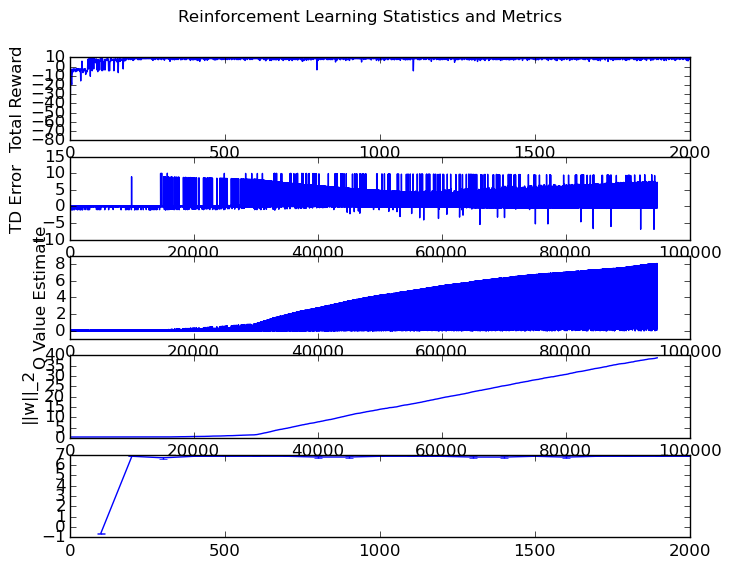

ReinforcementLearning.DiscretePolicy(ReinforcementLearning.DiscreteActionSpace{Tuple{Int64,Int64}}([(1,0),(-1,0),(0,1),(0,-1)]),feature_function,[6.91128,6.85647,0.214918,-0.0335506,0.283079,-0.0299666,0.0201112,0.0463429,0.00962369,-0.0425765  …  -0.0317579,0.0288903,0.00228773,0.00535764,0.0151077,-0.0258338,0.0506987,0.118766,0.725812,0.414625],ReinforcementLearning.NullFeatureExpander{Tuple{Int64,Int64}}(Dict((0,-1)=>4,(1,0)=>1,(0,1)=>3,(-1,0)=>2)))

Episode 2000; Simulation 100, Average Total Reward: 6.847+/-0.002, 95% Confidence Interval: (6.844,6.85						 

In [47]:
trained_policy = solve(solver,bbm,policy)

## Evaluate Policy
Basically just run a couple of simulations -- the simulator api is a subset of the stuff you see in solver

In [48]:
sim = Simulator(discount=1.,nb_sim=50,nb_timesteps=250,visualizer=visualize) #stuff...

ReinforcementLearning.Simulator(1.0,MersenneTwister(Base.dSFMT.DSFMT_state(Int32[-1878228090,1073167410,-2128431889,1073557860,-1357051276,1073482711,2116741946,1073582577,1801057705,1073211568  …  -1696413121,1072698256,-1267179353,1072765318,-2056471310,-929776493,-892727657,-341633801,382,1071500065]),[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],382,UInt32[0x000392fa]),MersenneTwister(Base.dSFMT.DSFMT_state(Int32[925593359,1073097610,-40215726,1073623399,1247437416,1073184766,1992028333,1073241897,-1003785101,1073160368  …  152366299,1073314948,1747315678,1073508326,-851108235,1583873678,-1549051359,1151679880,382,32739]),[3.28491e-316,5.93373e-321,6.06221e-316,7.10341e-316,0.0,0.0,5.62691e-316,6.94738e-310,6.60453e-316,4.94066e-324  …  4.59916e-316,4.59937e-316,7.90505e-323,3.95253e-323,403.18,538.777,403.49,7.95446e-322,4.59982e-316,6.22687e-316],382,UInt32[0xfee0e674,0x00000016]),50,250,true,10,visualize,ReinforcementLearning.History(0,0),

In [49]:
#returns average reward for now...
R_avg = simulate(sim,bbm,trained_policy)

(8.75,0.0,1.0)

Interact.Slider{Int64}(Signal{Int64}(13, nactions=0),"i",13,1:26,true)

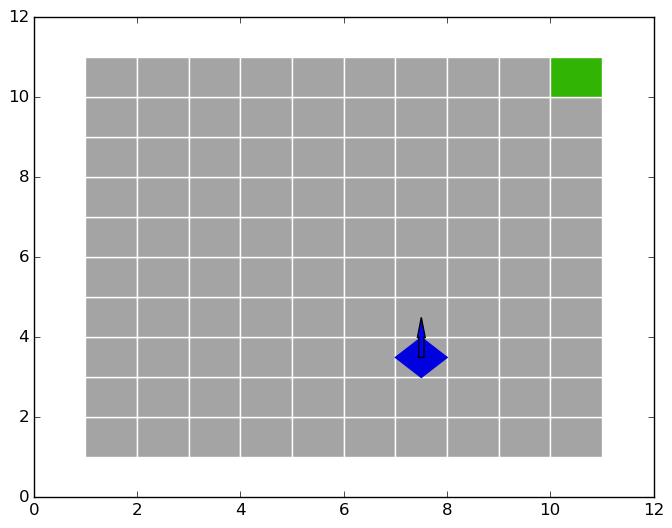

Simulation 50, Average Total Reward: 8.75+/-0.0, 95% Confidence Interval: (8.75,8.75						 

In [50]:
visualize(m,sim.hist.S,sim.hist.A)
#note: joint features gets 8.82
#note disjoint features gets: 

Note that we have to call visualize externally. Currently getting the visualization to work two or three function calls in isn't quite working.